In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import json
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import HDFStore,DataFrame
import pandas as pd

%matplotlib inline 

<h2>Prepare inputs for ML</h2>
<h4>Simple model. </h4>
Inputs: X = name (DSID, scope, ...), panda jobs in last x days, replica used in last x days, users in last x days.
Data are integrals of the above distribution in the measurement period.<br> 
Output: Y = used/not used in next x days.
Data are collected in prediction period<br><br>
The actual prediction is then checked for the weeks after the prediction period

- add all data for popularity measurement: sum up over panda ids, replicas, users
- add data for prediction: calculate number of accessed

<h3>Tried:</h3>
- measure 4 days, predict 3 days 
- measure 1 week, predict 1 week
- measure 26*7 days = 182 (6 months), predict 1 week (CMS model [arXiv:1602.07226])
- measure all 2016, predict all 2017

<h3>First, open files</h3>


In [4]:
#Open files and returns a dictionary of dataframes, key is date
def openFiles(start, end):
    
    dt = start
    dataFrames = {}
    step = datetime.timedelta(days=1)
    
    #loop over all results
    while dt < end:
    
        filename = 'DataPopularity_data/store_'+str(dt)+'.h5'
        df = pd.read_hdf(filename, 'result')       
        dataFrames[dt]=df
        dt += step     
    
    #print(dataFrames)
    return dataFrames

In [5]:
#open daily summaries and create dictionary of DataFrames, key is date
start = datetime.date(2017, 1, 1)          # measurement: starting date
ndays = 365                                 # Total range of input data

dataFrames = openFiles(start, start+ datetime.timedelta(days=int(ndays)) )
print(len(dataFrames))

365


<h3>Functions to create dataframes with data from last x days (summed over site, user, pandaids), and add new column with number of accesses for next x days</h3>


In [6]:
#merge dataframes used for popularity measurement (used for inputs) -> gets the integral of distributions

def mergeDF_measurement(df, df_new):
    #print('Before')
    #display(df.shape)
    concatenated = pd.concat([df, df_new]) 
    #print('After')
    
    #drop date, sum over pandaids, sites, users, ...
    result = concatenated.groupby(['name','scope']).agg({"pandaid": np.sum, "user": np.sum,  "site": np.sum,
        "taskid": pd.Series.sum, "cputime": pd.Series.sum, "walltime": pd.Series.sum, "nevents": pd.Series.sum, 
        "nfiles": pd.Series.sum, "size": pd.Series.sum   # sum over unique pandaids, taskids, sites, users. Get the total/day for all the rest  
    }).reset_index()
  
    #display(df_new.shape)
    #display(result.shape)
    
    return result

In [7]:
#merge dataframes used for prediction (used for outputs)

def mergeDF_prediction(df, df_new):
    #print('Before')
    #display(df.shape)
    #display(df_new.shape)
    
    #save only interesting columns and rename
    df_new = df_new[['name', 'pandaid']] 
    df_new = df_new.rename(index=str, columns={"pandaid":"accessed"})
    
    #merge and sum over accessed
    result = pd.merge(df, df_new, how='left', on=['name'])  
    #result = df.add(df_new).combine_first(df)
    
    #remove double access column created by merging: is there a smarter way?
    if 'accessed_x' in result.columns:
        result['accessed']=result['accessed_x']+result['accessed_y']
        result = result.drop('accessed_x', axis=1)
        result = result.drop('accessed_y', axis=1)                
                
    #print('After')
    #display(result.shape)    
    return result

In [8]:
#merge dataframes over all time range (popularity measurement+prediction) -> input+output

def mergeDF(dataFrames, start, time_meas, time_pred):

    end_meas = start + datetime.timedelta(days=time_meas)       # measurement: end date
    end_pred = end_meas + datetime.timedelta(days=time_pred)     # prediction: end date
    step = datetime.timedelta(days=1)
        
    dt = start
    df_new = dataFrames[dt]
    
    #loop over all results
    while dt < end_pred:
    
        df = dataFrames[dt]
        #print(df)
    
        if dt == start: #start with first dataframe
            #print('measurement '+dt.strftime('%Y-%m-%d'))
            df_new = df
        elif dt < end_meas: # add measurement data, just the same as first dataframe
            #print('measurement '+dt.strftime('%Y-%m-%d'))
            df_new = mergeDF_measurement(df_new ,df)
        else: # add prediction, for each dataset, just add accessed
            #print('prediction '+dt.strftime('%Y-%m-%d'))
            df_new = mergeDF_prediction(df_new,df)        
        
        dt += step     
        
    return df_new

## Automatization

create ML-ready inputs starting from date and defining time for measurement of popularity and test

In [9]:
# get DSID from dataset name (as a int)
def getDSID(name):

    sub = name.split('.')
    #print(sub)

    dsid = sub[1]
    
    #remove 00 for data
    if (dsid.startswith('00')):
        dsid  = dsid[2:]
    #print(dsid)
    return(int(dsid))  

In [10]:
# get ptag from dataset name (as a int)
def getPtag(name):

    sub = name.split('.')
    #print(sub)
    last = len(sub)
    tags = sub[last-1]
    #print(tags)
    ptag=0
    subtags = tags.split('_')
    #print(subtags)
    for i in subtags:
        if (i.startswith('p')): # takes always the last one
            ptag = int(i[1:])
            #print(i)
    return(ptag)      

In [11]:
# get Type from dataset name (DOAD_*)
def getType(name):

    sub = name.split('.')
    #print(sub)

    dstype = name
    for i in sub:
        if (i.startswith('DAOD_')): # takes always the last one
            dstype = i
    #print(dstype)
    return(dstype)      

In [12]:
# get positive numbers
def isPositive(number):
    if (number>0):
        return 1
    else:
        return 0

In [11]:
#df_new = dataFrames[datetime.date(2016, 3, 1)]
#df_new['type'] = df_new['name'].apply(getType)
#df_new.head(5)

In [13]:
def toML(dataFrames, start, time_meas, time_pred):    

    #start = datetime.date(2017, 2, 15)         # measurement: starting date
    #time_meas = 7                              # popularity measurement: # of days
    #time_pred = time_meas                      # popularity prediction: # of days    

    df_new = mergeDF(dataFrames, start, time_meas, time_pred)  

    #some manipulations to get DSID, ptags, convert accessed to binary
    df_new['dsid'] = df_new['name'].apply(getDSID)
    df_new['ptag'] = df_new['name'].apply(getPtag)
    df_new['type'] = df_new['name'].apply(getType)

    #rescale numerical inputs
    #from sklearn.preprocessing import StandardScaler

    #scaler = StandardScaler() 

    #df_new['pandaid_scaled'] = scaler.fit_transform(df_new['pandaid'].astype(float).values.reshape(-1, 1)) 
    #df_new['site_scaled'] = scaler.fit_transform(df_new['site'].astype(float).values.reshape(-1, 1)) 
    #df_new['user_scaled'] = scaler.fit_transform(df_new['user'].astype(float).values.reshape(-1, 1)) 
    #df_new['ptag_scaled'] = scaler.fit_transform(df_new['ptag'].astype(float).values.reshape(-1, 1)) 
    #df_new['dsid_scaled'] = scaler.fit_transform(df_new['dsid'].astype(float).values.reshape(-1, 1)) 

    #convert categorical to numerical

    #df_with_dummies = pd.get_dummies(df_new, columns = ['type', 'scope'] )

    #X = df_with_dummies.drop(['pandaid','name', 'site', 'user', 'dsid', 'ptag', 'Y'], axis=1)
    #Y = df_with_dummies['Y']
    
    #finally, store to file
    store = HDFStore('DataPopularity_ML/simpleModel_start_'+str(start)+'_meas_'+str(time_meas)+'_pred_'+str(time_pred)+'.h5')
    store['X'] = df_new.drop(['accessed'], axis=1)
    store['Y'] = df_new['accessed'].apply(isPositive)
    store.close()
    
    return

<h3>Tried:</h3>
- measure 4 days, predict 3 days 
- measure 1 week, predict 1 week
- measure 26*7 days = 182 (6 months), predict 1 week (CMS model [arXiv:1602.07226])

In [17]:
start = datetime.date(2017, 12, 22)         # measurement: starting date

#CMS model
#time_meas = 26*7                           # popularity measurement: # of days
#time_pred = 7                              # popularity prediction: # of days    

#1 week measure, 1 week predict
time_meas = 7                              # popularity measurement: # of days
time_pred = 7                              # popularity prediction: # of days    

#4 days measure, 3 days predict
#time_meas = 4                              # popularity measurement: # of days
#time_pred = 3                              # popularity prediction: # of days    

#make weekly dataframes for 1 year
for x in range(0, int(20 - time_meas/time_pred)):
    strt = start +x*datetime.timedelta(days=7) # measure on weekly basis
    print('Start processing week '+str(x) + ' start date '+str(strt))
    toML(dataFrames, strt, time_meas, time_pred)

Start processing week 0 start date 2017-12-22


KeyError: datetime.date(2018, 1, 1)

## Development

create ML-ready inputs starting from date and defining time for measurement of popularity and test

In [14]:
start = datetime.date(2017, 2, 1)         # measurement: starting date
time_meas = 7                             # popularity measurement: # of days
time_pred = 7                              # popularity prediction: # of days    

df_new = mergeDF(dataFrames, start, time_meas, time_pred)  
#df_new = dataFrames[start]

#check for duplicates
duplicated = df_new.duplicated('name', keep = False)
df_new[duplicated].name.tolist()
#display(duplicated)
#l=df_new.name.tolist()
#set([x for x in l if l.count(x) > 1])

[]

In [15]:
print(df_new.shape)
print('Accessed '+str(df_new[df_new.accessed >=1].shape[0]))

(22769, 12)
Accessed 134


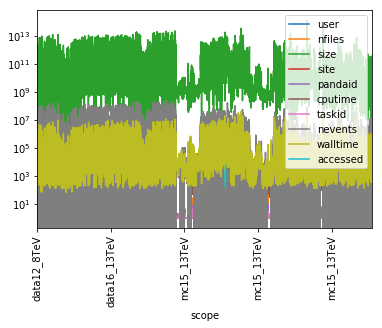

In [16]:
#plot
plt.figure(figsize=(50,10))
df_new.sort_values('scope').plot('scope')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [17]:
display(df_new.sort_values('pandaid',ascending=False).head(5))

,name,scope,user,nfiles,size,site,pandaid,cputime,taskid,nevents,walltime,accessed
4968,data16_13TeV.00302393.physics_Main.merge.DAOD_...,data16_13TeV,21,13149,22067239969049,30,5266,8416423,23,253022652,11962432,NaN
5607,data16_13TeV.00303338.physics_Main.merge.DAOD_...,data16_13TeV,20,14285,20734885758668,33,4987,6208774,23,213666342,7974160,4545.0
5110,data16_13TeV.00302872.physics_Main.merge.DAOD_...,data16_13TeV,26,14061,23224685091610,23,4704,6970249,30,241139768,11336117,4986.0
4565,data16_13TeV.00301932.physics_Main.merge.DAOD_...,data16_13TeV,22,11562,18477118375205,35,4586,6595331,24,207753768,9269532,NaN
5767,data16_13TeV.00303638.physics_Main.merge.DAOD_...,data16_13TeV,16,11150,17950989304516,32,4492,6026570,21,207126424,7411516,NaN


<h3>Still some arrangement to do</h3>
extract p_tags, DSID, convert accessed to binary

In [18]:
#name = df_new['name'][0]
#print(getDSID(name))
#print(getPtag(name))

df_new['dsid'] = df_new['name'].apply(getDSID)
df_new['ptag'] = df_new['name'].apply(getPtag)
df_new['type'] = df_new['name'].apply(getType)
df_new['Y'] = df_new['accessed'].apply(isPositive)
df_new = df_new.drop(['accessed'], axis=1)

display(df_new.sort_values('pandaid',ascending=False).head(5))
df_new.shape

,name,scope,user,nfiles,size,site,pandaid,cputime,taskid,nevents,walltime,dsid,ptag,type,Y
4968,data16_13TeV.00302393.physics_Main.merge.DAOD_...,data16_13TeV,21,13149,22067239969049,30,5266,8416423,23,253022652,11962432,302393,2689,DAOD_SUSY1,0
5607,data16_13TeV.00303338.physics_Main.merge.DAOD_...,data16_13TeV,20,14285,20734885758668,33,4987,6208774,23,213666342,7974160,303338,2689,DAOD_SUSY1,1
5110,data16_13TeV.00302872.physics_Main.merge.DAOD_...,data16_13TeV,26,14061,23224685091610,23,4704,6970249,30,241139768,11336117,302872,2689,DAOD_SUSY1,1
4565,data16_13TeV.00301932.physics_Main.merge.DAOD_...,data16_13TeV,22,11562,18477118375205,35,4586,6595331,24,207753768,9269532,301932,2667,DAOD_SUSY1,0
5767,data16_13TeV.00303638.physics_Main.merge.DAOD_...,data16_13TeV,16,11150,17950989304516,32,4492,6026570,21,207126424,7411516,303638,2689,DAOD_SUSY1,0


(22769, 15)

<h3>Rescale numerical inputs</h3>

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

df_new['pandaid_scaled'] = scaler.fit_transform(df_new['pandaid'].astype(float).values.reshape(-1, 1)) 
df_new['site_scaled'] = scaler.fit_transform(df_new['site'].astype(float).values.reshape(-1, 1)) 
df_new['user_scaled'] = scaler.fit_transform(df_new['user'].astype(float).values.reshape(-1, 1)) 
df_new['ptag_scaled'] = scaler.fit_transform(df_new['ptag'].astype(float).values.reshape(-1, 1)) 
df_new['dsid_scaled'] = scaler.fit_transform(df_new['dsid'].astype(float).values.reshape(-1, 1)) 

display(df_new.sort_values('pandaid_scaled',ascending=False).head(5))
df_new.shape

,name,scope,user,nfiles,size,site,pandaid,cputime,taskid,nevents,walltime,dsid,ptag,type,Y,pandaid_scaled,site_scaled,user_scaled,ptag_scaled,dsid_scaled
4968,data16_13TeV.00302393.physics_Main.merge.DAOD_...,data16_13TeV,21,13149,22067239969049,30,5266,8416423,23,253022652,11962432,302393,2689,DAOD_SUSY1,0,20.486740,8.422019,7.304438,-0.293609,-0.843159
5607,data16_13TeV.00303338.physics_Main.merge.DAOD_...,data16_13TeV,20,14285,20734885758668,33,4987,6208774,23,213666342,7974160,303338,2689,DAOD_SUSY1,1,19.385137,9.346142,6.915242,-0.293609,-0.820264
5110,data16_13TeV.00302872.physics_Main.merge.DAOD_...,data16_13TeV,26,14061,23224685091610,23,4704,6970249,30,241139768,11336117,302872,2689,DAOD_SUSY1,1,18.267741,6.265733,9.250418,-0.293609,-0.831554
4565,data16_13TeV.00301932.physics_Main.merge.DAOD_...,data16_13TeV,22,11562,18477118375205,35,4586,6595331,24,207753768,9269532,301932,2667,DAOD_SUSY1,0,17.801830,9.962223,7.693634,-0.366071,-0.854329
5767,data16_13TeV.00303638.physics_Main.merge.DAOD_...,data16_13TeV,16,11150,17950989304516,32,4492,6026570,21,207126424,7411516,303638,2689,DAOD_SUSY1,0,17.430681,9.038101,5.358458,-0.293609,-0.812995


(22769, 20)

<h3>Convert categorical inputs to numbers</h3>

In [20]:
#using pd dummies

#cols_to_transform = [ 'name', 'type', 'scope', 'dsid', 'ptag' ]
df_with_dummies = pd.get_dummies(df_new, columns = ['type', 'scope'] )
display(df_with_dummies.sort_values('pandaid',ascending=False).head(5))
df_with_dummies.shape

,name,user,nfiles,size,site,pandaid,cputime,taskid,nevents,walltime,...,type_DAOD_TAUP1,type_DAOD_TAUP3,type_DAOD_TOPQ1,type_DAOD_TOPQ4,type_DAOD_TRUTH1,type_DAOD_ZMUMU,scope_data12_8TeV,scope_data15_13TeV,scope_data16_13TeV,scope_mc15_13TeV
4968,data16_13TeV.00302393.physics_Main.merge.DAOD_...,21,13149,22067239969049,30,5266,8416423,23,253022652,11962432,...,0,0,0,0,0,0,0,0,1,0
5607,data16_13TeV.00303338.physics_Main.merge.DAOD_...,20,14285,20734885758668,33,4987,6208774,23,213666342,7974160,...,0,0,0,0,0,0,0,0,1,0
5110,data16_13TeV.00302872.physics_Main.merge.DAOD_...,26,14061,23224685091610,23,4704,6970249,30,241139768,11336117,...,0,0,0,0,0,0,0,0,1,0
4565,data16_13TeV.00301932.physics_Main.merge.DAOD_...,22,11562,18477118375205,35,4586,6595331,24,207753768,9269532,...,0,0,0,0,0,0,0,0,1,0
5767,data16_13TeV.00303638.physics_Main.merge.DAOD_...,16,11150,17950989304516,32,4492,6026570,21,207126424,7411516,...,0,0,0,0,0,0,0,0,1,0


(22769, 94)

<h3>Finally prepare and store inputs for machine learning</h3>

In [21]:
X = df_with_dummies.drop(['pandaid','name', 'site', 'user', 'ptag', 'dsid', 'Y'], axis=1)
display(X.head(5))
X.shape

Y=df_with_dummies['Y']
display(Y.head(5))
Y.shape

,nfiles,size,cputime,taskid,nevents,walltime,pandaid_scaled,site_scaled,user_scaled,ptag_scaled,...,type_DAOD_TAUP1,type_DAOD_TAUP3,type_DAOD_TOPQ1,type_DAOD_TOPQ4,type_DAOD_TRUTH1,type_DAOD_ZMUMU,scope_data12_8TeV,scope_data15_13TeV,scope_data16_13TeV,scope_mc15_13TeV
0,2,7108543540,163570,1,26414,166161,-0.297617,-0.511165,-0.479483,-4.456904,...,0,0,0,0,0,0,1,0,0,0
1,1,4383200205,166825,1,13754,168862,-0.301565,-0.511165,-0.479483,-4.456904,...,0,0,0,0,0,0,1,0,0,0
2,6,24137985596,704124,2,82688,725171,-0.281823,-0.203124,-0.090287,-4.456904,...,0,0,0,0,0,0,1,0,0,0
3,18,71982233896,1711421,2,258863,1864410,-0.234442,-0.203124,-0.090287,-4.456904,...,0,0,0,0,0,0,1,0,0,0
4,4,15658619966,360172,3,56036,380169,-0.289720,0.104917,0.298910,-4.456904,...,0,0,0,0,0,0,1,0,0,0


0    0
1    0
2    0
3    0
4    0
Name: Y, dtype: int64

(22769,)

In [41]:
#store to file
store = HDFStore('DataPopularity_ML/simpleModel_start_'+str(start)+'_step_'+str(time_meas)+'.h5')
store['X'] = X
store['Y'] = Y

store.close()

<h3>Facultative: study correlations between inputs for signal (accessed) and background (not accessed)</h3>

In [22]:
#using labelEncoder -> not very useful since order matters in ML...

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_enc = df_new.copy()
df_enc['type_enc'] = label_encoder.fit_transform(df_enc['type'])
df_enc['scope_enc'] = label_encoder.fit_transform(df_enc['scope'])
display(df_enc.sort_values('pandaid',ascending=False).head(5))
df_enc.shape

,name,scope,user,nfiles,size,site,pandaid,cputime,taskid,nevents,...,ptag,type,Y,pandaid_scaled,site_scaled,user_scaled,ptag_scaled,dsid_scaled,type_enc,scope_enc
4968,data16_13TeV.00302393.physics_Main.merge.DAOD_...,data16_13TeV,21,13149,22067239969049,30,5266,8416423,23,253022652,...,2689,DAOD_SUSY1,0,20.486740,8.422019,7.304438,-0.293609,-0.843159,55,2
5607,data16_13TeV.00303338.physics_Main.merge.DAOD_...,data16_13TeV,20,14285,20734885758668,33,4987,6208774,23,213666342,...,2689,DAOD_SUSY1,1,19.385137,9.346142,6.915242,-0.293609,-0.820264,55,2
5110,data16_13TeV.00302872.physics_Main.merge.DAOD_...,data16_13TeV,26,14061,23224685091610,23,4704,6970249,30,241139768,...,2689,DAOD_SUSY1,1,18.267741,6.265733,9.250418,-0.293609,-0.831554,55,2
4565,data16_13TeV.00301932.physics_Main.merge.DAOD_...,data16_13TeV,22,11562,18477118375205,35,4586,6595331,24,207753768,...,2667,DAOD_SUSY1,0,17.801830,9.962223,7.693634,-0.366071,-0.854329,55,2
5767,data16_13TeV.00303638.physics_Main.merge.DAOD_...,data16_13TeV,16,11150,17950989304516,32,4492,6026570,21,207126424,...,2689,DAOD_SUSY1,0,17.430681,9.038101,5.358458,-0.293609,-0.812995,55,2


(22769, 22)

,nfiles,size,cputime,taskid,nevents,walltime,Y,pandaid_scaled,site_scaled,user_scaled,ptag_scaled,dsid_scaled,type_enc,scope_enc
0,2,7108543540,163570,1,26414,166161,0,-0.297617,-0.511165,-0.479483,-4.456904,-3.016565,47,0
1,1,4383200205,166825,1,13754,168862,0,-0.301565,-0.511165,-0.479483,-4.456904,-3.009151,47,0
2,6,24137985596,704124,2,82688,725171,0,-0.281823,-0.203124,-0.090287,-4.456904,-3.006753,47,0
3,18,71982233896,1711421,2,258863,1864410,0,-0.234442,-0.203124,-0.090287,-4.456904,-3.005226,47,0
4,4,15658619966,360172,3,56036,380169,0,-0.289720,0.104917,0.298910,-4.456904,-3.005178,47,0


signal (134, 14)
background (22635, 14)


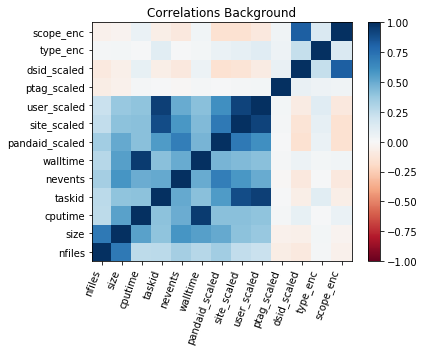

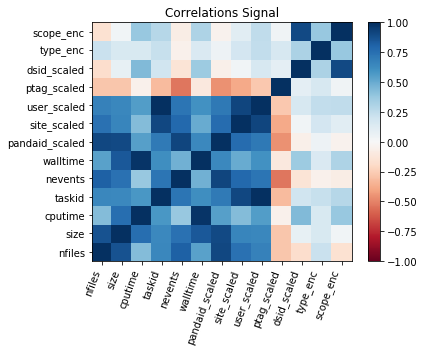

In [23]:
XY = df_enc.drop(['pandaid','name', 'site', 'user', 'type', 'scope', 'dsid', 'ptag'], axis=1)
display(XY.head(5))
XY.shape

bg = XY.Y < 0.5
sig = XY.Y > 0.5

def correlations(data, title = '', **kwds):
    """Calculate pairwise correlation between features.    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of correlation values if you do not need the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations "+title)

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(XY[bg].drop('Y', 1), 'Background')
correlations(XY[sig].drop('Y', 1), 'Signal')
print('signal '+str(XY[sig].shape))
print('background '+str(XY[bg].shape))

<h3>Facultative: study popularity as function of measurement time</h3>

0/363 10/363 20/363 30/363 40/363 50/363 60/363 70/363 80/363 90/363 100/363 110/363 120/363 130/363 140/363 150/363 160/363 170/363 180/363 190/363 200/363 210/363 220/363 230/363 240/363 250/363 260/363 270/363 280/363 290/363 300/363 310/363 320/363 330/363 340/363 350/363 360/363 
Interval: 1


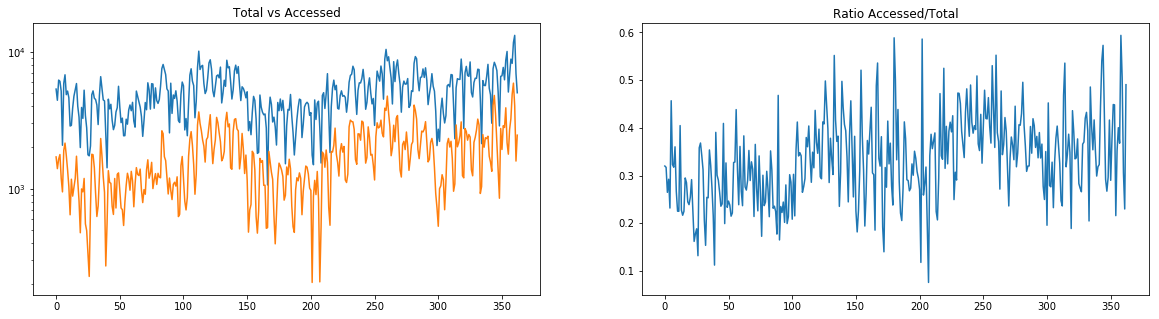

0/357 10/357 20/357 30/357 40/357 50/357 60/357 70/357 80/357 90/357 100/357 110/357 120/357 130/357 140/357 150/357 160/357 170/357 180/357 190/357 200/357 210/357 220/357 230/357 240/357 250/357 260/357 270/357 280/357 290/357 300/357 310/357 320/357 330/357 340/357 350/357 
Interval: 4


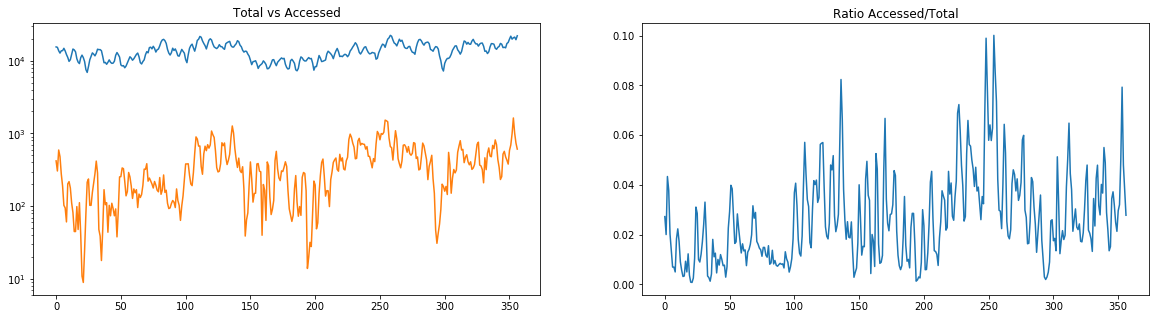

0/351 10/351 20/351 30/351 40/351 50/351 60/351 70/351 80/351 90/351 100/351 110/351 120/351 130/351 140/351 150/351 160/351 170/351 180/351 190/351 200/351 210/351 220/351 230/351 240/351 250/351 260/351 270/351 280/351 290/351 300/351 310/351 320/351 330/351 340/351 350/351 
Interval: 7


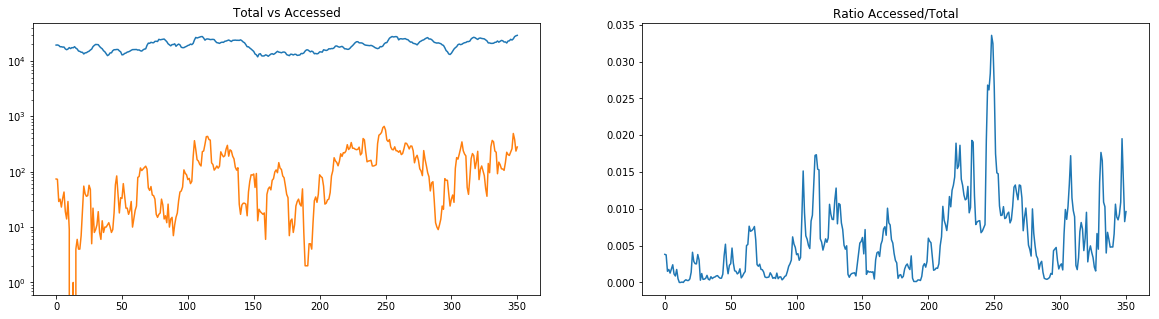

0/345 10/345 20/345 30/345 40/345 50/345 60/345 70/345 80/345 90/345 100/345 110/345 120/345 130/345 140/345 150/345 160/345 170/345 180/345 190/345 200/345 210/345 220/345 230/345 240/345 250/345 260/345 270/345 280/345 290/345 300/345 310/345 320/345 340/345 
Interval: 10


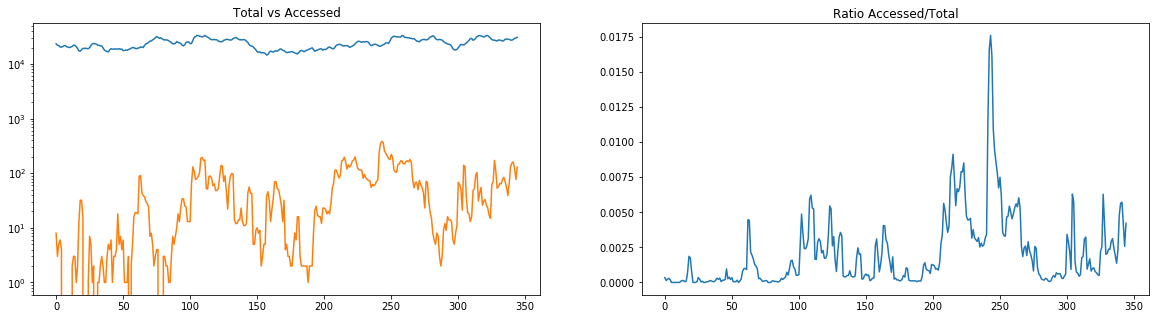

0/339 10/339 20/339 30/339 40/339 50/339 60/339 70/339 80/339 90/339 100/339 

In [ ]:
#study popularity as function of measurement time

start = datetime.date(2016, 3, 1)   
time_meas = 15                             # popularity measurement: # of days
time_pred = time_meas                      # popularity prediction: # of days    
time_step = 3                              # time step for changing measurement period     
ndays = 365                                # Total range of input data

for i in np.arange(1, time_meas+1, time_step):
    
    Total = []
    Accessed = []
    Ratio = []
    actual_ndays = ndays - i - i  # set actual measument+observation period not to go out of bounds
    
    #print('Start processing '+str(actual_ndays)+' days')

    for n in np.arange(0, actual_ndays, 1):
 
        #vary starting time    
        df_new = mergeDF(dataFrames, start+ datetime.timedelta(days=int(n)) , int(i), int(i))
        if not n%10:  print(str(n)+'/'+str(actual_ndays), end=" ") 
        #display(df_new.sort_values('pandaid',ascending=False).head(10))
        #display(df_new.sort_values('accessed',ascending=False).head(10))

        total = df_new[df_new['pandaid'] >=1].index.tolist()
        accessed = df_new[df_new['accessed'] >=1].index.tolist()    
        #print(str(start)+ ' Total: '+str(len(total))+' accessed: '+str(len(accessed)))
        Total.append(len(total))
        Accessed.append(len(accessed))
        Ratio.append(len(accessed)/len(total))

    print('\n'+'Interval: '+str(i))
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(Total)
    plt.plot(Accessed)
    plt.title('Total vs Accessed')
    plt.yscale('log')

    plt.subplot(122)
    plt.title('Ratio Accessed/Total')
    plt.plot(Ratio)
    plt.show()    

In [1]:
#study popularity as function of measurement time -> measure 1 month, predict 1 month

start = datetime.date(2016, 5, 15)   
time_meas = 30                             # popularity measurement: # of days
time_pred = time_meas                      # popularity prediction: # of days    
time_step = 29                             # time step for changing measurement period     
ndays = 365                                # Total range of input data

for i in np.arange(1, time_meas+1, time_step):
    
    Total = []
    Accessed = []
    Ratio = []
    actual_ndays = ndays - i - i  # set actual measument+observation period not to go out of bounds
    
    print('Start processing '+str(actual_ndays)+' days')
    print('Time interval: '+str(i)+' days')
    
    for n in np.arange(0, actual_ndays, 1):
 
        #vary starting time    
        df_new = mergeDF(dataFrames, start+ datetime.timedelta(days=int(n)) , int(i), int(i))
        if not n%10:  print(str(n)+'/'+str(actual_ndays), end=" ") 
        #display(df_new.sort_values('pandaid',ascending=False).head(10))
        #display(df_new.sort_values('accessed',ascending=False).head(10))

        total = df_new[df_new['pandaid'] >=1].index.tolist()
        accessed = df_new[df_new['accessed'] >=1].index.tolist()    
        #print(str(start)+ ' Total: '+str(len(total))+' accessed: '+str(len(accessed)))
        Total.append(len(total))
        Accessed.append(len(accessed))
        Ratio.append(len(accessed)/len(total))

    print('\n'+'Interval: '+str(i))
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(Total)
    plt.plot(Accessed)
    plt.title('Total vs Accessed')
    plt.yscale('log')

    plt.subplot(122)
    plt.title('Ratio Accessed/Total')
    plt.plot(Ratio)
    plt.show()    

NameError: name 'datetime' is not defined

<h3>Study popularity as function of measurement time for C3PO datasets</h3>

In [27]:
#read dictionary with name, c3po replication dates from Thomas
import json

with open('DataPopularity_data/dataset-timestring.json') as json_data:
    d = json.load(json_data)

In [28]:
#create a dictionary where date is key, and value is list of datasets created by C3PO 
c3po = {}

for name, dates in d.items():
    #print(key, value)
    if 'DAOD_' in name: #take only DAOD
        for date in dates:
            #round to next day
            dt = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").date()+ datetime.timedelta(days=1)
            
            if dt in c3po:
                c3po[dt].append(name)
            else:
                c3po[dt] = [name] 
            
#display(sorted(c3po.keys()))
display('C3PO entries: '+str(len(c3po.keys())))  

'C3PO entries: 142'

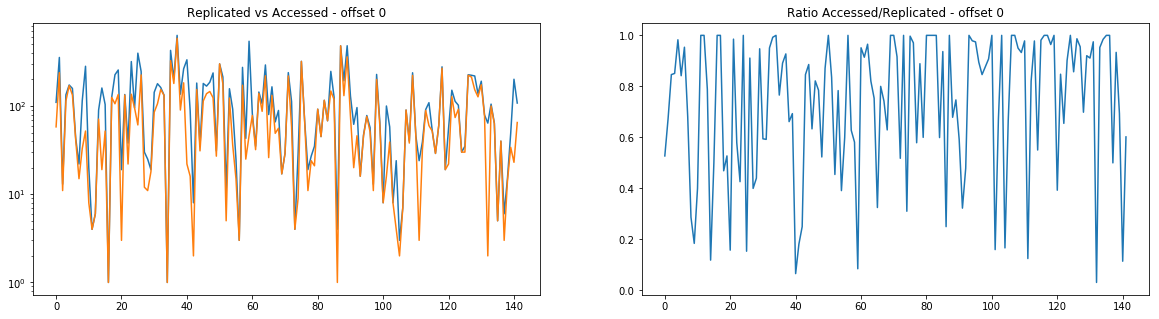

Replicated 17258 Accessed 12172 Ratio 0.7052960945648395


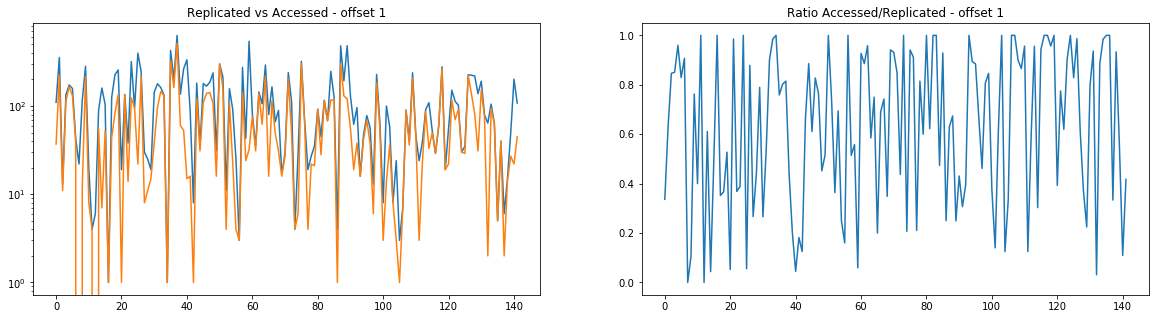

Replicated 17258 Accessed 10455 Ratio 0.6058060030130954


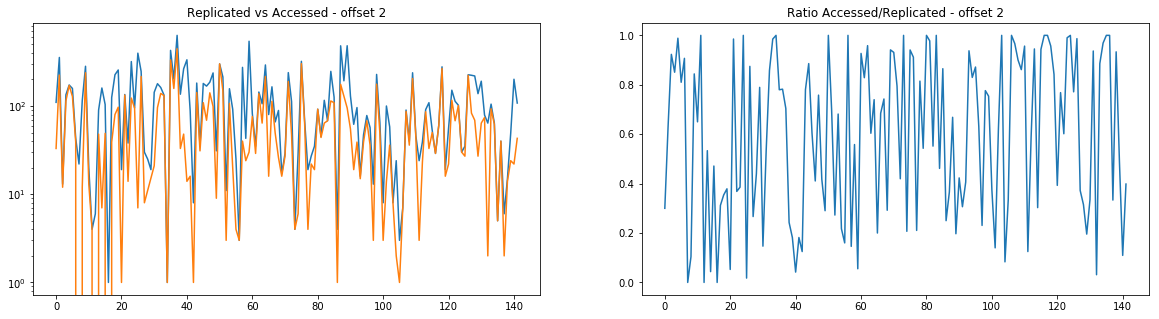

Replicated 17258 Accessed 9685 Ratio 0.5611890137907057


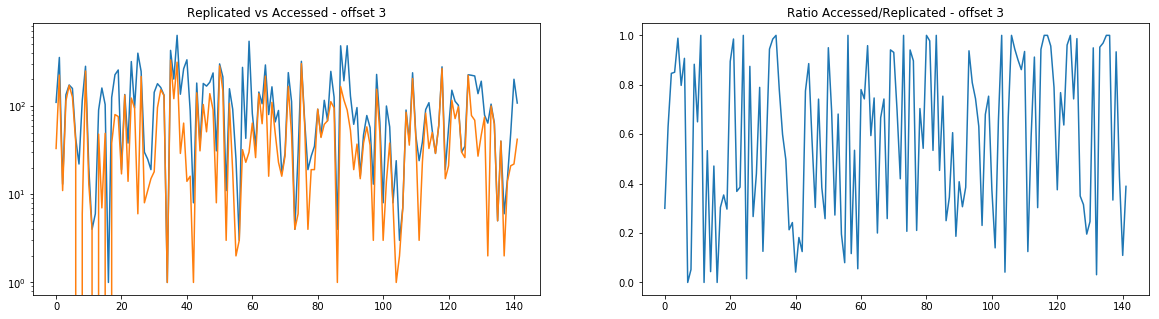

Replicated 17258 Accessed 9317 Ratio 0.5398655695909144


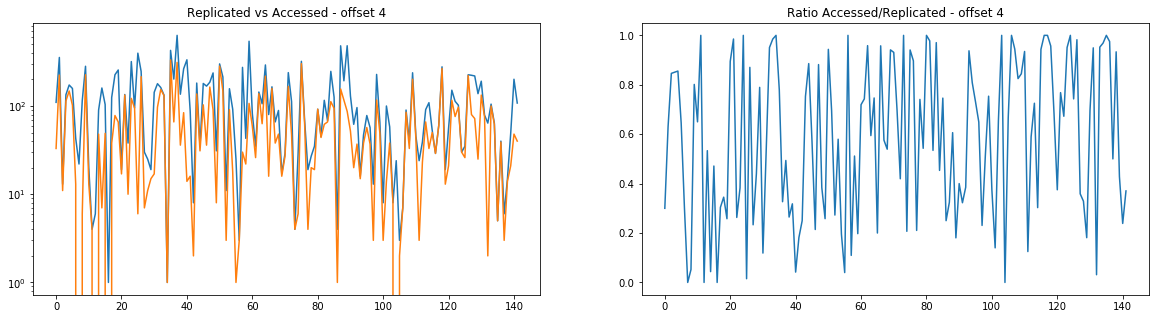

Replicated 17258 Accessed 9327 Ratio 0.5404450110093869


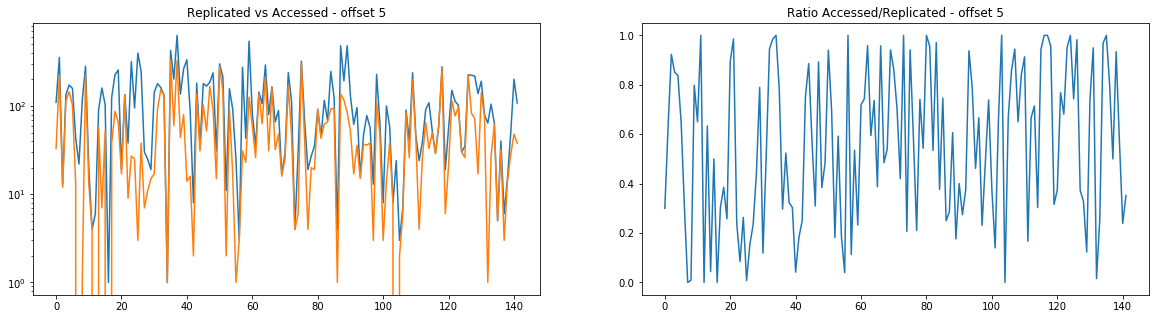

Replicated 17258 Accessed 8874 Ratio 0.5141963147525785


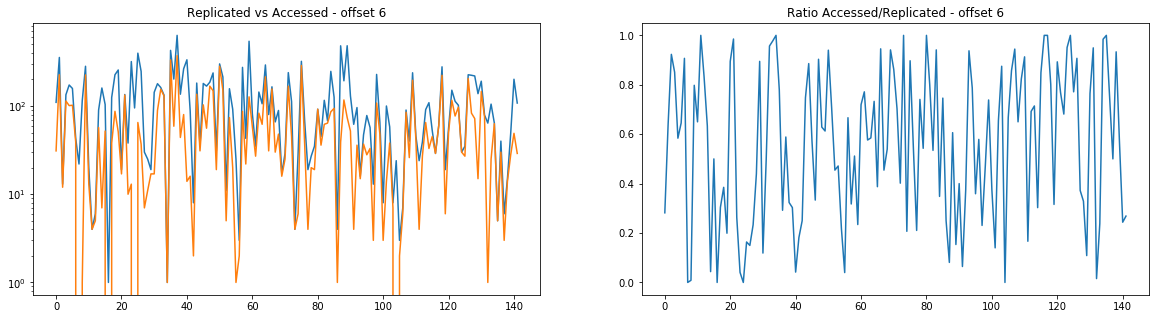

Replicated 17258 Accessed 8742 Ratio 0.5065476880287403


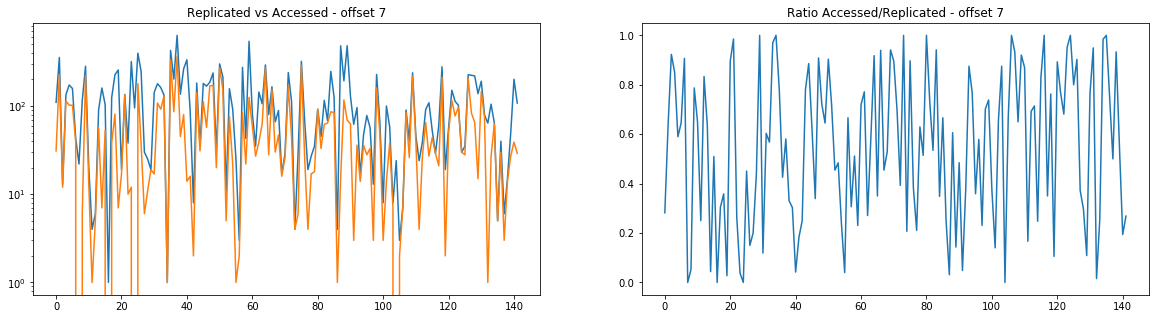

Replicated 17258 Accessed 8766 Ratio 0.5079383474330745


In [29]:
#study C3PO efficiency

start = datetime.date(2016, 8, 26)         # start of C3PO data
ndays = 169 #169                                # Total range of input data

for offset in range(0,8):
    Total = []
    Accessed = []
    Ratio = []

    #loop over measurement period
    date = start
    for day in np.arange(0, ndays):
    
        #print('Measurement for day '+str(day)+' corresponding to '+str(date))
    
        #get list of datasets created by C3PO on date
        if date in c3po:
            datasets = c3po[date]
            total = len(datasets)# Total datasets replicated by C3PO
            Total.append(total) 
            #print('Replicated by C3PO '+str(total))
            df_week = dataFrames[date + datetime.timedelta(days=int(offset))].name
        
            #merge dataframes in next 7 days
            for n in np.arange(1, 8):            
                newdate = date + datetime.timedelta(days=int(n+offset))
                df_week = pd.concat([df_week, dataFrames[newdate].name])
                #print('Adding datasets accessed on '+str(newdate))
        
            df_week = df_week.drop_duplicates()
            accessed = df_week[df_week.isin(datasets)]

            if (total<accessed.shape[0]):
                print('Error, more accessed then replicated '+str(datasets))
                display(accessed.name.tolist())
            #print('Accessed '+str(accessed.shape[0]))
            Ratio.append(accessed.shape[0]/total)
            Accessed.append(accessed.shape[0])    
        #else:
            #Total.append(0)
            #Accessed.append(0)
            #Ratio.append(0)        
            #print('No C3PO replications')
            
        date += datetime.timedelta(days=1) 
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(Total, label = 'Replicated')
    plt.plot(Accessed, label = 'Accessed')
    plt.title('Replicated vs Accessed - offset '+str(offset))
    plt.yscale('log')

    plt.subplot(122)
    plt.title('Ratio Accessed/Replicated - offset '+str(offset))
    plt.plot(Ratio)
    plt.show()    
    
    print("Replicated "+str(sum(Total))+" Accessed "+str(sum(Accessed))+" Ratio "+str(sum(Accessed)/sum(Total)))

In [24]:
print('Hello')
for i in range(0, 10):
    print(str(i))

Hello
0
1
2
3
4
5
6
7
8
9
